# Q4 — PINN com solução analítica (elasticidade 2D)

A solução analítica é:
\[
u_x(x,y) = \sin(\pi y), \qquad
u_y(x,y) = Q(x-x^2)(e^{y^2}-1).
\]

As tensões seguem da elasticidade linear:
\[
\sigma = \lambda \,\mathrm{tr}(\varepsilon)\,I + 2\mu\,\varepsilon.
\]

**Condições de contorno:**
- Fundo \(y=0\): \(u_x=0,\;u_y=0\);
- Topo \(y=1\): \(u_x=0\), \(\sigma_{yy}=\sigma_{yy}^{\text{target}}(x)\);
- Laterais \(x=0,1\): \(u_y=0\), \(\sigma_{xx}=0\).

Usaremos **BCs soft**, pois facilitam a declaração das condições de tração.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

print("device:", DEVICE)


device: cpu


## Parâmetros físicos e amostragem


In [3]:
# Material
E  = 210e9
nu = 0.30
lam = E*nu/((1+nu)*(1-2*nu))
mu  = E/(2*(1+nu))

L = 1.0
Q = 1.0

N_domain  = 4000
N_bnd     = 600

W_PDE, W_DIR, W_NEU = 1.0, 10.0, 1.0
SIG_SCALE = E

def sample_domain(n):
    x = np.random.rand(n,1)*L
    y = np.random.rand(n,1)*L
    XY = np.hstack([x,y])
    return torch.from_numpy(XY).to(DEVICE)

def sample_boundary_each(n):
    k = n//4
    x0 = np.random.rand(k,1)*L; y0 = np.zeros((k,1))
    x1 = np.random.rand(k,1)*L; y1 = np.ones((k,1))*L
    x2 = np.zeros((k,1));      y2 = np.random.rand(k,1)*L
    x3 = np.ones((k,1))*L;     y3 = np.random.rand(k,1)*L
    XYb = np.vstack([np.hstack([x0,y0]),
                     np.hstack([x1,y1]),
                     np.hstack([x2,y2]),
                     np.hstack([x3,y3])])
    return torch.from_numpy(XYb).to(DEVICE)

XYd = sample_domain(N_domain).requires_grad_(True)
XYb = sample_boundary_each(N_bnd).requires_grad_(True)


## Rede neural e operadores diferenciais


In [4]:
class MLP(nn.Module):
    def __init__(self, layers=[2,64,64,64,2], act=nn.Tanh):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net += [nn.Linear(layers[i], layers[i+1])]
            if i < len(layers)-2:
                net += [act()]
        self.net = nn.Sequential(*net)
        self.apply(self.xavier_init)
    @staticmethod
    def xavier_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, XY): return self.net(XY)

net = MLP().to(DEVICE)

def grads(u, XY):
    return torch.autograd.grad(u, XY, grad_outputs=torch.ones_like(u),
                               retain_graph=True, create_graph=True)[0]

def ux_uy(net, XY):
    u = net(XY)
    return u[:, :1], u[:, 1:]

def strains(net, XY):
    ux, uy = ux_uy(net, XY)
    gux, guy = grads(ux, XY), grads(uy, XY)
    uxx, uxy = gux[:,0:1], gux[:,1:2]
    uyx, uyy = guy[:,0:1], guy[:,1:2]
    return uxx, uyy, 0.5*(uxy+uyx)

def stresses(net, XY):
    exx, eyy, exy = strains(net, XY)
    tr = exx+eyy
    sxx = lam*tr + 2*mu*exx
    syy = lam*tr + 2*mu*eyy
    sxy = 2*mu*exy
    return sxx, syy, sxy

def div_sigma(net, XY):
    sxx, syy, sxy = stresses(net, XY)
    dsxx_dx = grads(sxx, XY)[:,0:1]; dsxy_dy = grads(sxy, XY)[:,1:2]
    dsxy_dx = grads(sxy, XY)[:,0:1]; dsyy_dy = grads(syy, XY)[:,1:2]
    return dsxx_dx+dsxy_dy, dsxy_dx+dsyy_dy


## Solução analítica e condição de tração


In [5]:
def u_analytic(XY):
    XY_np = XY.detach().cpu().numpy()
    x, y = XY_np[:,0:1], XY_np[:,1:2]
    return np.sin(np.pi*y), Q*(x-x**2)*(np.exp(y**2)-1.0)

def stress_analytic(XY):
    XY_np = XY.detach().cpu().numpy()
    x, y = XY_np[:,0:1], XY_np[:,1:2]
    divu = 2*Q*y*np.exp(y**2)*(x-x**2)
    sxx = lam*divu
    syy = (lam+2*mu)*divu
    sxy = mu*(np.pi*np.cos(np.pi*y) + Q*(1-2*x)*(np.exp(y**2)-1.0))
    return sxx, syy, sxy

def syy_top_target(x_tensor):
    return (lam+2*mu)*2*Q*np.exp(1.0)*(x_tensor-x_tensor**2)


## Função de perda (PDE + BCs soft, com pesos)


In [6]:
def loss_total(net, XYd, XYb):
    rx, ry = div_sigma(net, XYd)
    loss_pde = (rx.pow(2).mean()+ry.pow(2).mean())/(SIG_SCALE**2)

    xb, yb = XYb[:,0:1], XYb[:,1:2]

    # fundo
    mask_btm = (yb<=1e-12)
    loss_btm = torch.tensor(0., device=DEVICE)
    if mask_btm.any():
        ux_btm, uy_btm = ux_uy(net, XYb[mask_btm.flatten()])
        loss_btm = ux_btm.pow(2).mean()+uy_btm.pow(2).mean()

    # topo
    mask_top = (yb>=1-1e-12)
    loss_top = torch.tensor(0., device=DEVICE)
    if mask_top.any():
        XY_top = XYb[mask_top.flatten()]
        ux_top,_ = ux_uy(net, XY_top)
        syy_pred = stresses(net, XY_top)[1]
        syy_tgt = syy_top_target(XY_top[:,0:1])
        loss_top = ux_top.pow(2).mean() + ((syy_pred-syy_tgt)/SIG_SCALE).pow(2).mean()

    # laterais
    loss_lat = torch.tensor(0., device=DEVICE)
    for m in [(xb<=1e-12),(xb>=1-1e-12)]:
        if m.any():
            XY_side = XYb[m.flatten()]
            _, uy_side = ux_uy(net, XY_side)
            sxx_side = stresses(net, XY_side)[0]
            loss_lat += uy_side.pow(2).mean() + (sxx_side/SIG_SCALE).pow(2).mean()

    loss_bc = loss_btm+loss_top+loss_lat
    total = W_PDE*loss_pde + W_DIR*(loss_btm) + W_NEU*(loss_top+loss_lat)
    return total, dict(total=float(total.detach().cpu()))


## Treinamento: Adam (aquecimento) → L-BFGS (refino)


In [7]:
def train_adam(net, XYd, XYb, iters=4000, lr=5e-4, every=200):
    opt = optim.Adam(net.parameters(), lr=lr)
    hist=[]
    for k in range(1,iters+1):
        opt.zero_grad()
        L,parts=loss_total(net,XYd,XYb)
        L.backward(); opt.step()
        hist.append(parts['total'])
        if k%every==0: print(f"Adam {k}: loss={parts['total']:.3e}")
    return np.array(hist)

def train_lbfgs(net, XYd, XYb, max_iter=200):
    opt = optim.LBFGS(net.parameters(), max_iter=max_iter)
    def closure():
        opt.zero_grad(); L,_=loss_total(net,XYd,XYb); L.backward(); return L
    opt.step(closure)

hist_adam = train_adam(net,XYd,XYb,iters=4000,lr=5e-4,every=200)
train_lbfgs(net,XYd,XYb)


Adam 200: loss=6.824e-01
Adam 400: loss=4.815e-01
Adam 600: loss=3.132e-01
Adam 800: loss=1.836e-01
Adam 1000: loss=1.061e-01
Adam 1200: loss=7.335e-02
Adam 1400: loss=6.223e-02
Adam 1600: loss=5.678e-02
Adam 1800: loss=5.209e-02
Adam 2000: loss=4.765e-02
Adam 2200: loss=4.278e-02
Adam 2400: loss=3.693e-02
Adam 2600: loss=2.896e-02
Adam 2800: loss=2.144e-02
Adam 3000: loss=1.668e-02
Adam 3200: loss=1.348e-02
Adam 3400: loss=1.099e-02
Adam 3600: loss=9.055e-03
Adam 3800: loss=7.573e-03
Adam 4000: loss=6.514e-03


## Curva da Loss (fase Adam)


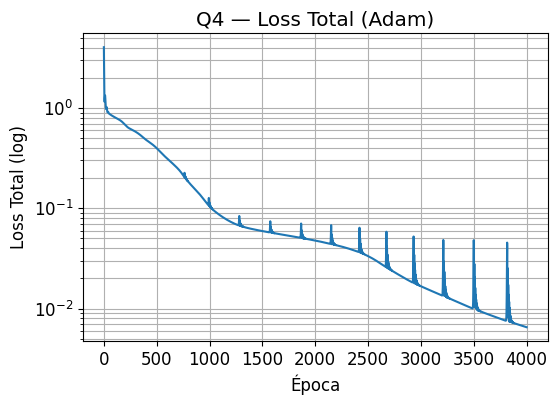

In [8]:
plt.figure(figsize=(6,4))
plt.semilogy(hist_adam)
plt.xlabel("Época"); plt.ylabel("Loss Total (log)")
plt.title("Q4 — Loss Total (Adam)")
plt.grid(True,which="both")
plt.show()


## Avaliação: Analítico × PINN × Erro Absoluto


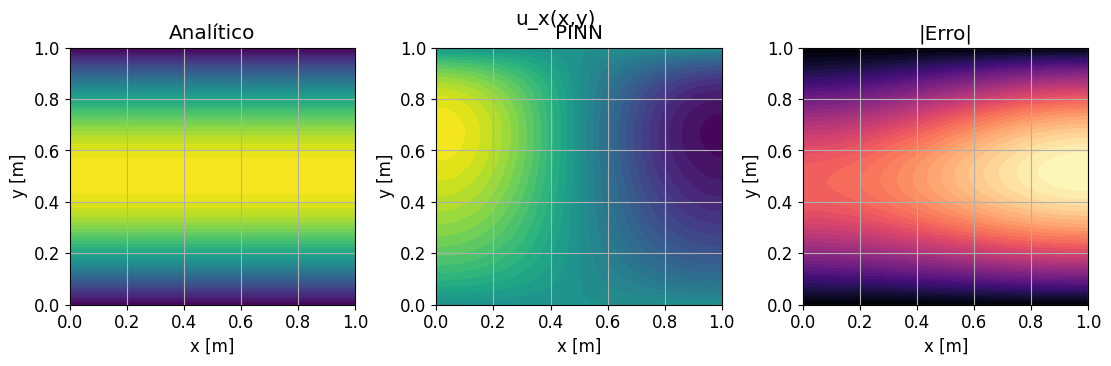

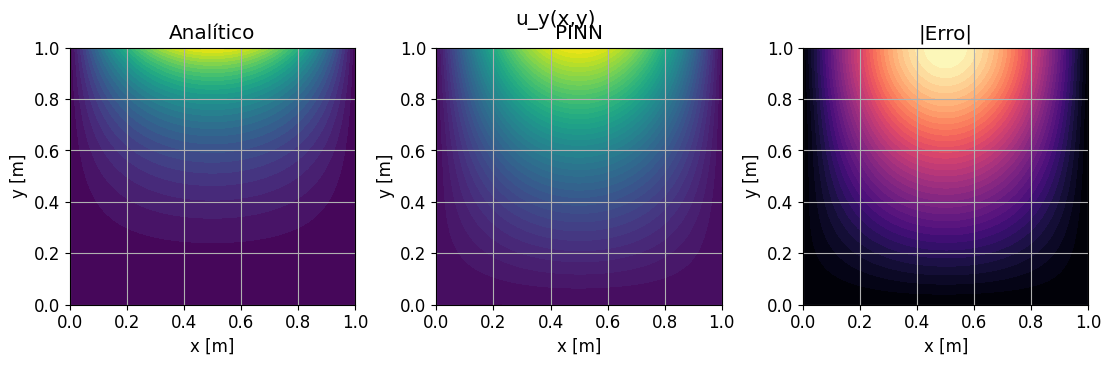

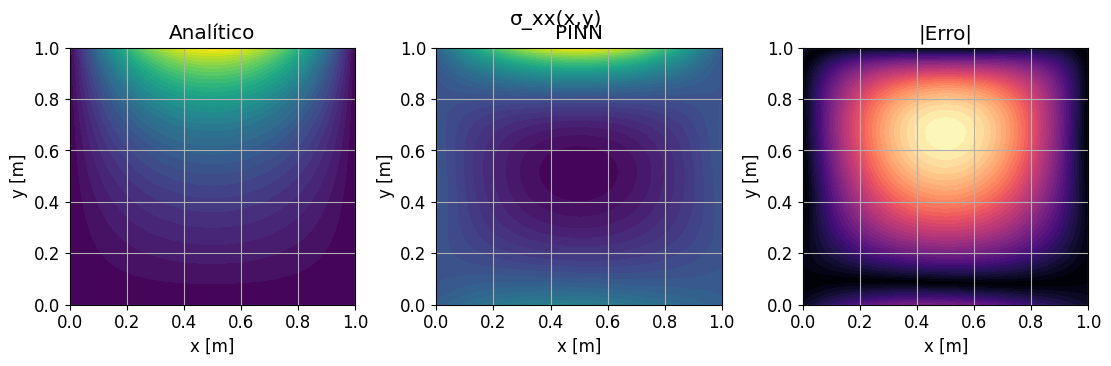

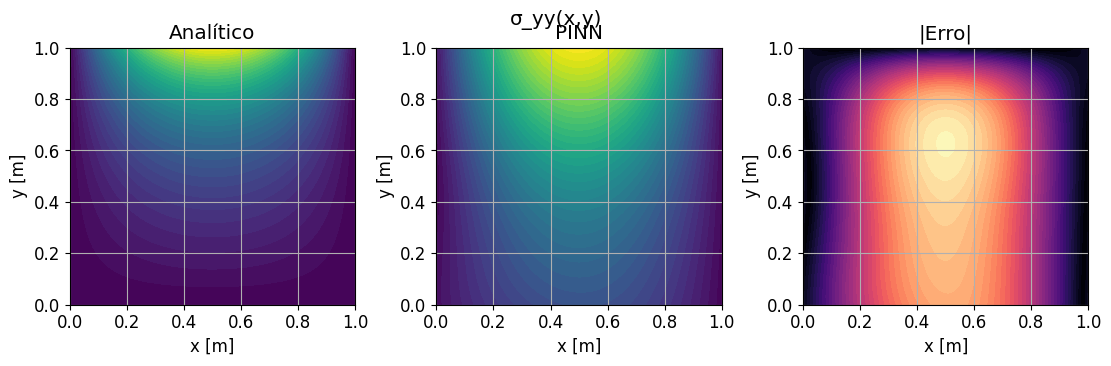

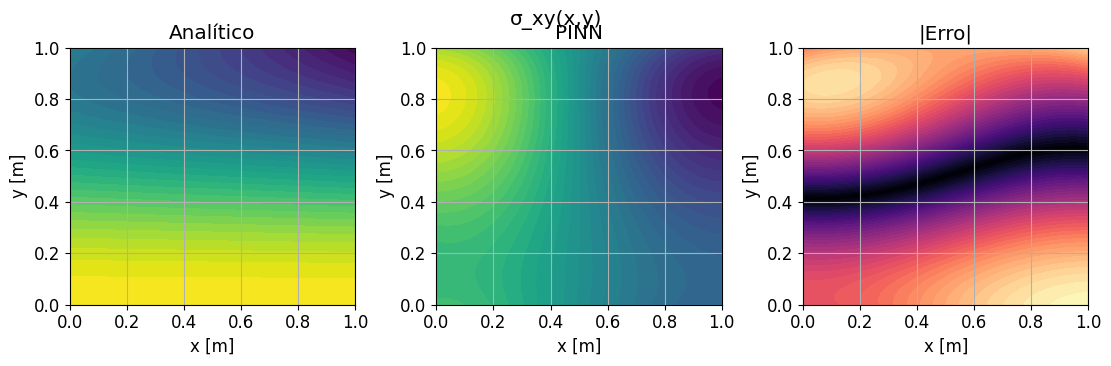

In [9]:
def grid_eval(net,nx=121,ny=121):
    xs=np.linspace(0,L,nx); ys=np.linspace(0,L,ny)
    XX,YY=np.meshgrid(xs,ys)
    XYg=torch.from_numpy(np.stack([XX.ravel(),YY.ravel()],axis=1)).to(DEVICE).requires_grad_(True)
    ux_p,uy_p=ux_uy(net,XYg)
    sxx_p,syy_p,sxy_p=stresses(net,XYg)
    ux_p=ux_p.detach().cpu().numpy().reshape(YY.shape)
    uy_p=uy_p.detach().cpu().numpy().reshape(YY.shape)
    sxx_p=sxx_p.detach().cpu().numpy().reshape(YY.shape)
    syy_p=syy_p.detach().cpu().numpy().reshape(YY.shape)
    sxy_p=sxy_p.detach().cpu().numpy().reshape(YY.shape)
    ux_a,uy_a=u_analytic(XYg); sxx_a,syy_a,sxy_a=stress_analytic(XYg)
    return XX,YY,(ux_a.reshape(YY.shape),uy_a.reshape(YY.shape),
                  sxx_a.reshape(YY.shape),syy_a.reshape(YY.shape),sxy_a.reshape(YY.shape)),\
                 (ux_p,uy_p,sxx_p,syy_p,sxy_p)

def plot_triptych(title,XX,YY,A,P):
    E=np.abs(P-A)
    fig,axs=plt.subplots(1,3,figsize=(11,3.4),constrained_layout=True)
    im0=axs[0].contourf(XX,YY,A,40); axs[0].set_title("Analítico")
    im1=axs[1].contourf(XX,YY,P,40); axs[1].set_title("PINN")
    im2=axs[2].contourf(XX,YY,E,40,cmap="magma"); axs[2].set_title("|Erro|")
    for ax in axs: ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
    plt.suptitle(title,y=1.03); plt.show()

XX,YY,A,P=grid_eval(net)
ux_a,uy_a,sxx_a,syy_a,sxy_a=A
ux_p,uy_p,sxx_p,syy_p,sxy_p=P

plot_triptych("u_x(x,y)",XX,YY,ux_a,ux_p)
plot_triptych("u_y(x,y)",XX,YY,uy_a,uy_p)
plot_triptych("σ_xx(x,y)",XX,YY,sxx_a,sxx_p)
plot_triptych("σ_yy(x,y)",XX,YY,syy_a,syy_p)
plot_triptych("σ_xy(x,y)",XX,YY,sxy_a,sxy_p)
